In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn import metrics
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import multiprocessing
multiprocessing.freeze_support()
import warnings

c:\Users\ninag\mambaforge\envs\suppl\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
df = pd.read_csv("../tagging/tagged_data.csv")

In [3]:
# deleting additional information
df = df.drop([df.columns[0], df.columns[2], df.columns[3], df.columns[4],df.columns[6], df.columns[7], df.columns[8],
              df.columns[9], df.columns[10], df.columns[11],df.columns[12], df.columns[13], df.columns[14],df.columns[15],
              df.columns[16], df.columns[17], df.columns[18], df.columns[19], df.columns[20], df.columns[21], df.columns[22],
             df.columns[23],df.columns[24], df.columns[25], df.columns[26],df.columns[27], df.columns[28], df.columns[29],df.columns[30],
              df.columns[31], df.columns[32], df.columns[33], df.columns[36]], axis=1)
print(df.head())

   ID                                            reviews  Correct review   \
0   1  I have a bad hair lose, i really concern to lo...                1   
1   2  Biotin has been a game-changer for my hair. Af...                1   
2   3                        Not bad but could be better                1   
3   4  For more than a month, I took Nature Made® Hai...                1   
4   5          This is a test review post done by Amar 4                1   

   Incorrect review   
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


In [4]:
# split data
train_df, val_df = train_test_split(df, test_size=0.05)
print(train_df.shape, val_df.shape)

(950, 4) (50, 4)


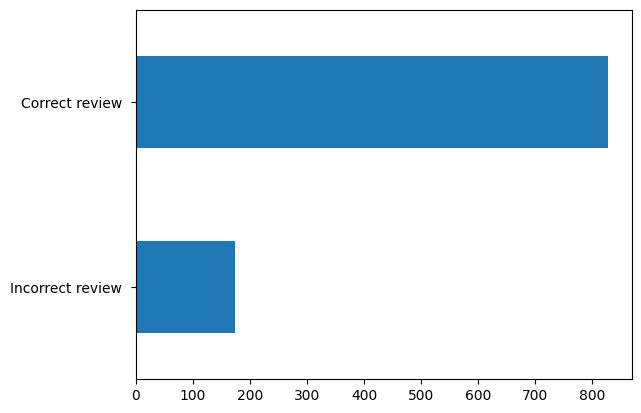

In [5]:
# the distribution of the tags
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")
plt.show()

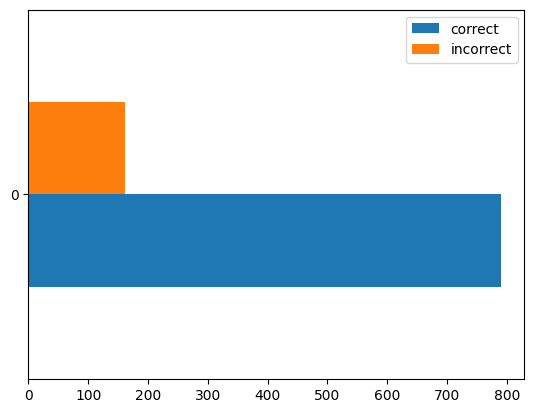

In [6]:
# the distribution of the correct and incorrect tags
train_correct = train_df[train_df.iloc[:, 2] == 1]
train_incorrect = train_df[train_df.iloc[:, 3] == 1]
pd.DataFrame(dict(
  correct=[len(train_correct)],
  incorrect=[len(train_incorrect)]
)).plot(kind='barh')
plt.show()

In [7]:
# output of data quantity
count_ones = len(train_df[train_df.iloc[:, 2] == 1])
count_ones_2 = len(train_df[train_df.iloc[:, 3] == 1])
column_name = train_df.columns[2]
column_name_2 = train_df.columns[3]
print(column_name, count_ones, column_name_2, count_ones_2)

Correct review  790 Incorrect review  161


In [8]:
# sample only 200 correct reviews to combat the imbalance
train_df = pd.concat([
  train_incorrect,
  train_correct.sample(200)
])
print(train_df.shape, val_df.shape)

(361, 4) (50, 4)


In [9]:
# Tokenization
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [10]:
# a simple example
sample_row = df.iloc[7]
sample_comment = sample_row.reviews
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_comment)
print()
print(sample_labels.to_dict())

encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
  )
encoding.keys()
print(encoding.keys())
print(encoding["input_ids"].shape)
print(encoding["attention_mask"].shape)
print(encoding["input_ids"].squeeze()[:20])
print(encoding["attention_mask"].squeeze()[:20])
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])
# the end of the example

My hairline started to recede, had bald patches and my hair volume had decreased enormously. Probably due to menopause. I've been taking Biotin (5000mcg p/d) for 5 months now and the results are remarkable. First noticed fuller eye lashes and longer nails and now my hair volume seems to be  back to normal and the bald patches have become smaller. It's a pity that I can't upload before- & after photo's. No side effects up until now, hopefully none will come. Very happy; it's done wonders for my c,onfidence.

{'Correct review ': 1, 'Incorrect review ': 0}
dict_keys(['input_ids', 'attention_mask'])
torch.Size([1, 512])
torch.Size([1, 512])
tensor([  101,  1422,  1716,  2568,  1408,  1106,  1231, 19482,   117,  1125,
        18035, 14879,  1105,  1139,  1716,  3884,  1125, 10558,  7883,  1193])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
['[CLS]', 'My', 'hair', '##line', 'started', 'to', 're', '##cede', ',', 'had', 'bald', 'patches', 'and', 'my', 'hair', 'volume', 

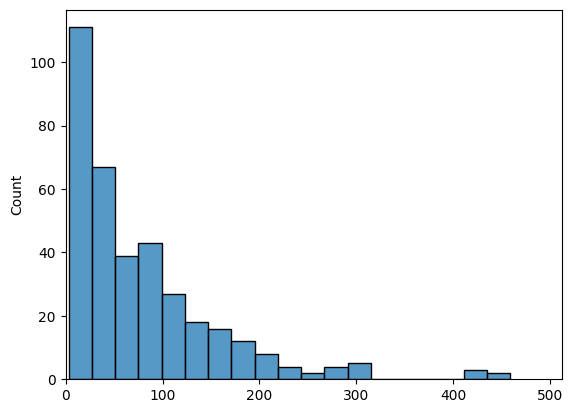

In [11]:
# the number of tokens per comment
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
      row["reviews"],
      max_length=512,
      truncation=True
    ))
    token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512])
plt.show()

MAX_TOKEN_COUNT = 512

In [12]:
# Dataset
warnings.filterwarnings("ignore", category=FutureWarning)


class CorrectReviewsDataset(Dataset):
    def __init__(
      self,
      data: pd.DataFrame,
      tokenizer: BertTokenizer,
      max_token_len: int = 128
    ):
      self.tokenizer = tokenizer
      self.data = data
      self.max_token_len = max_token_len
    def __len__(self):
      return len(self.data)
    def __getitem__(self, index: int):
      data_row = self.data.iloc[index]
      reviews = data_row.reviews
      labels = data_row[LABEL_COLUMNS]
      encoding = self.tokenizer.encode_plus(
        reviews,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
        )
      return dict(
        reviews=reviews,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        #labels = torch.FloatTensor(labels.iloc[0]) #debug but tensor([])
        #labels = torch.FloatTensor(labels)
        labels=torch.FloatTensor(labels.iloc[:])
      )


In [13]:
# a sample item from the dataset
train_dataset = CorrectReviewsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]

print(sample_item.keys())
print(sample_item["reviews"])
print(sample_item["labels"])
print(sample_item["input_ids"].shape)

dict_keys(['reviews', 'input_ids', 'attention_mask', 'labels'])
did not notice any real benefit.
tensor([0., 1.])
torch.Size([512])


In [14]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True).cuda()

In [15]:
train_dl = DataLoader(train_dataset, batch_size=8, num_workers=0)

In [16]:
sample_batch = next(iter(train_dl))  # must be 2 num_workers

In [17]:
sample_batch["input_ids"]

tensor([[  101,  1225,  1136,  ...,     0,     0,     0],
        [  101,  1198,  1408,  ...,     0,     0,     0],
        [  101,  1130, 13053,  ...,     0,     0,     0],
        ...,
        [  101,  1370,  1103,  ...,     0,     0,     0],
        [  101,  1198,  1328,  ...,     0,     0,     0],
        [  101, 14255,  1596,  ...,     0,     0,     0]])

In [18]:
print(sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape)

torch.Size([8, 512]) torch.Size([8, 512])


In [19]:
# BERT
with torch.no_grad():
    output = bert_model(sample_batch["input_ids"].cuda(), sample_batch["attention_mask"].cuda())
    print(output.last_hidden_state.shape, output.pooler_output.shape)
    print(bert_model.config.hidden_size)

torch.Size([8, 512, 768]) torch.Size([8, 768])
768


In [20]:
# custom dataset into a LightningDataModule
class CorrectReviewsDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = CorrectReviewsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = CorrectReviewsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=0
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=0
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=0
    )

In [21]:
# an instance of data module
N_EPOCHS = 10
BATCH_SIZE = 4
data_module = CorrectReviewsDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [22]:
# MODEL
class CorrectReviewsTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad(): # не сохраняем градиенты
            output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    def on_train_epoch_end(self):
        '''
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
        '''
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

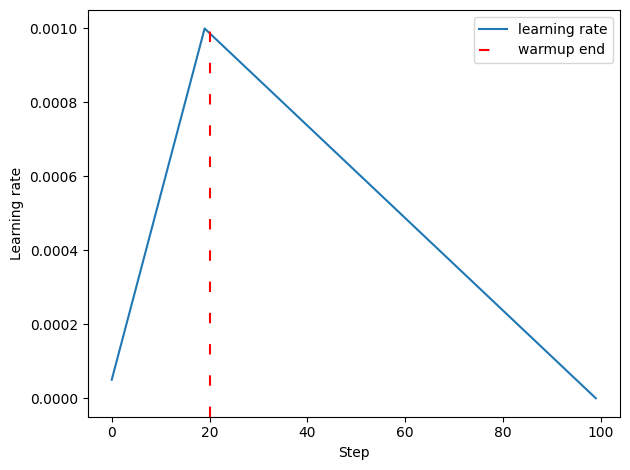

In [23]:
# Optimizer scheduler
dummy_model = nn.Linear(10, 1)
for param in dummy_model.parameters():
    param.requires_grad = True
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout()
plt.show()

In [24]:
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
print(warmup_steps, total_training_steps)

180 900


In [25]:
# an instance of the model
model: CorrectReviewsTagger = CorrectReviewsTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

In [26]:
# Evaluation
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)
print(torch.sigmoid(prediction))
print(criterion(torch.sigmoid(prediction), labels))

_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
print(predictions)
print(criterion(predictions, sample_batch["labels"]))

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])
tensor(0.8725)
tensor([[0.5468, 0.6050],
        [0.5513, 0.6014],
        [0.5661, 0.5986],
        [0.5583, 0.6149],
        [0.5650, 0.6032],
        [0.5468, 0.5914],
        [0.5557, 0.6008],
        [0.5391, 0.5561]], grad_fn=<SigmoidBackward0>)
tensor(0.6620, grad_fn=<BinaryCrossEntropyBackward0>)


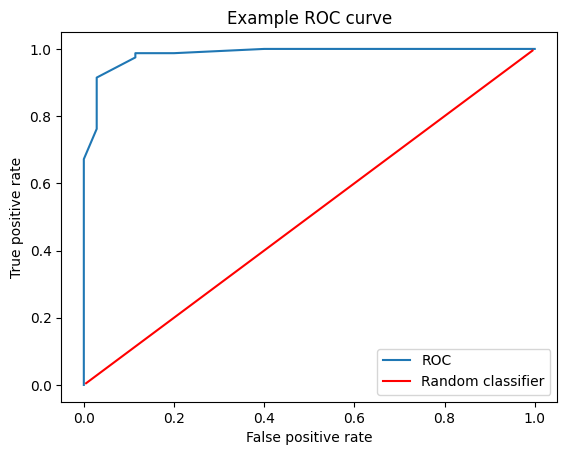

In [27]:
# ROC Curve
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show()

In [28]:
# Training

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [29]:
logger = TensorBoardLogger("lightning_logs", name="correct-reviews")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  accelerator="gpu",
  log_every_n_steps = 5
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 1.5 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.247   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ninag\mambaforge\envs\suppl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\ninag\mambaforge\envs\suppl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 91: 'val_loss' reached 0.71219 (best 0.71219), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 182: 'val_loss' reached 0.67485 (best 0.67485), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 273: 'val_loss' reached 0.65709 (best 0.65709), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 364: 'val_loss' reached 0.64026 (best 0.64026), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 455: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 546: 'val_loss' reached 0.63853 (best 0.63853), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 637: 'val_loss' reached 0.63734 (best 0.63734), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 728: 'val_loss' reached 0.63704 (best 0.63704), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 819: 'val_loss' reached 0.63694 (best 0.63694), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 910: 'val_loss' reached 0.63673 (best 0.63673), saving model to 'C:\\Users\\ninag\\Documents\\projects_students\\project_suppl\\git_test_parsing_1000\\BERT_1_version\\checkpoints\\best-checkpoint.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
